In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git  # NEW UPDATES AND MORE DETAILS
# !git clone https://github.com/suny-downstate-medical-center/S1_Thal_NetPyNE_Frontiers_2022
# import os
# os.chdir('S1_Thal_NetPyNE_Frontiers_2022/runSubNets')

In [3]:
import matplotlib
import os
os.chdir('../sim')

In [4]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [5]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets_E->EI_background'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 3.0*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.05
cfg.seeds = {'conn': 4322, 'stim': 1001, 'loc': 4322} 
cfg.hParams = {'celsius': 34, 'v_init': -69.5}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

In [6]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()

# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
cfg.loadcellsfromJSON = True

cfg.cao_secs = 1.2

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('cells/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cfg.cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cfg.cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cfg.cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cfg.cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cfg.cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = cfg.cellNumber[metype]

In [7]:
#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch8.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

# create custom list of spike times
cellsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]            
    cellsVSName[metype].append('presyn_'+cellLabel)

#------------------------------------------------------------------------------
cfg.cynradNumber = 1
cfg.fracmorphoradius = 1.0/14.0

excluderadius2a = (cfg.cynradNumber-1)*(0.5*cfg.fracmorphoradius)**2
excluderadius2b = (cfg.cynradNumber)*(0.5*cfg.fracmorphoradius)**2

cfg.Nmorpho = {}    
cfg.listmorphonumber = {}

print('radius from',420*np.sqrt(excluderadius2a),'to',420*np.sqrt(excluderadius2b),'micrometers')

#------------------------------------------------------------------------------
# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
       
    for cellLabel in cellsVSName[metype]: # all cells in metype

        mtype = cfg.popLabel[metype]    
        ii = int(cellLabel.split('_')[-1])
        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b:   

            if metype not in cfg.listmorphonumber.keys():
                cfg.listmorphonumber[metype] = []

            cfg.listmorphonumber[metype].append(ii)     

            if metype not in cfg.Nmorpho.keys():
                cfg.Nmorpho[metype] = 0

            cfg.Nmorpho[metype] += 1

#------------------------------------------------------------------------------
cfg.Epopsall = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
cfg.Ipops = []
cfg.Epops = [] 
cfg.S1pops = []
cfg.S1cells = []
cfg.popLabelEl = {}

for metype in  cfg.Nmorpho.keys(): # metype      
    if  cfg.Nmorpho[metype] > 0:  
        cfg.S1cells.append(metype)
        mtype = cfg.popLabel[metype]            
        if mtype in cfg.Epopsall:            
            if mtype not in cfg.Epops:
                cfg.Epops.append(mtype)
                cfg.S1pops.append(mtype)
                cfg.popLabelEl[mtype] = [] 
            cfg.popLabelEl[mtype].append(metype)            
        else:            
            if mtype not in cfg.Ipops:                
                cfg.Ipops.append(mtype)  
                cfg.S1pops.append(mtype)  
                cfg.popLabelEl[mtype] = [] 
            cfg.popLabelEl[mtype].append(metype)      

#------------------------------------------------------------------------------  
#
#------------------------------------------------------------------------------  
cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells


radius from 0.0 to 15.0 micrometers


In [8]:
#------------------------------------------------------------------------------
# Network 
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 2082.0
cfg.sizeX = 420.0 # r = 210 um and hexagonal side length = 230.9 um
cfg.sizeZ = 420.0

#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# Connectivity
#------------------------------------------------------------------------------
## S1->S1
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

#-----------------------------------------------------------------------------
## Th->S1
cfg.connect_ThVecStim_S1 = True

cfg.TC_S1 = {}
cfg.TC_S1['VPL_sTC'] = True
cfg.TC_S1['VPM_sTC'] = True
cfg.TC_S1['POm_sTC_s1'] = True

cfg.frac_Th_S1 = 1.0

## Run only selected populations (me-types)

In [9]:
cfg.S1pops

['L1_DAC',
 'L1_HAC',
 'L1_NGC-SA',
 'L1_SLAC',
 'L23_DBC',
 'L23_LBC',
 'L23_MC',
 'L23_NBC',
 'L23_PC',
 'L4_BP',
 'L4_DBC',
 'L4_LBC',
 'L4_NBC',
 'L4_PC',
 'L4_SP',
 'L4_SS',
 'L5_BTC',
 'L5_LBC',
 'L5_MC',
 'L5_NBC',
 'L5_SBC',
 'L5_STPC',
 'L5_TTPC1',
 'L5_TTPC2',
 'L6_BPC',
 'L6_IPC',
 'L6_LBC',
 'L6_MC',
 'L6_NBC',
 'L6_SBC',
 'L6_TPC_L1',
 'L6_TPC_L4',
 'L6_UTPC']

In [10]:
cfg.Nmorpho

{'L1_DAC_cNA': 1,
 'L1_HAC_bNA': 1,
 'L1_NGC-SA_cNA': 3,
 'L1_SLAC_cNA': 1,
 'L23_DBC_bNA': 1,
 'L23_LBC_bAC': 1,
 'L23_LBC_cAC': 1,
 'L23_LBC_cNA': 1,
 'L23_LBC_dNA': 1,
 'L23_MC_cNA': 1,
 'L23_NBC_cNA': 2,
 'L23_PC_cAD': 29,
 'L4_BP_bAC': 1,
 'L4_DBC_cIR': 1,
 'L4_LBC_dNA': 1,
 'L4_NBC_cNA': 1,
 'L4_PC_cAD': 13,
 'L4_SP_cAD': 5,
 'L4_SS_cAD': 4,
 'L5_BTC_bAC': 1,
 'L5_BTC_cAC': 1,
 'L5_LBC_cST': 1,
 'L5_LBC_dNA': 1,
 'L5_MC_bIR': 1,
 'L5_MC_cNA': 1,
 'L5_NBC_cST': 1,
 'L5_SBC_bNA': 1,
 'L5_SBC_cAC': 1,
 'L5_SBC_dNA': 1,
 'L5_STPC_cAD': 2,
 'L5_TTPC1_cAD': 7,
 'L5_TTPC2_cAD': 5,
 'L6_BPC_cAD': 12,
 'L6_IPC_cAD': 24,
 'L6_LBC_bST': 1,
 'L6_MC_cAC': 1,
 'L6_NBC_cAC': 1,
 'L6_NBC_cNA': 1,
 'L6_NBC_cST': 2,
 'L6_SBC_cAC': 1,
 'L6_TPC_L1_cAD': 5,
 'L6_TPC_L4_cAD': 6,
 'L6_UTPC_cAD': 12}

In [11]:
subPopLabels = cfg.S1pops[16:24] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
subPopLabels

['L5_BTC',
 'L5_LBC',
 'L5_MC',
 'L5_NBC',
 'L5_SBC',
 'L5_STPC',
 'L5_TTPC1',
 'L5_TTPC2']

In [12]:
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

cfg.cellNumber[metype]
cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
for metype in cfg.cellParamLabels:
    print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
    
#------------------------------------------------------------------------------  
## Change popNumber
#------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 25
# cfg.popNumber[cfg.popLabel[metype]] = 25
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   

L5_BTC_bAC 13 L5_BTC 76
L5_BTC_cAC 50 L5_BTC 76
L5_LBC_cST 37 L5_LBC 210
L5_LBC_dNA 37 L5_LBC 210
L5_MC_bIR 44 L5_MC 395
L5_MC_cNA 16 L5_MC 395
L5_NBC_cST 40 L5_NBC 201
L5_SBC_bNA 9 L5_SBC 25
L5_SBC_cAC 9 L5_SBC 25
L5_SBC_dNA 7 L5_SBC 25
L5_STPC_cAD 302 L5_STPC 302
L5_TTPC1_cAD 2403 L5_TTPC1 2403
L5_TTPC2_cAD 2003 L5_TTPC2 2003


In [13]:
cfg.cellParamLabels

['L5_BTC_bAC',
 'L5_BTC_cAC',
 'L5_LBC_cST',
 'L5_LBC_dNA',
 'L5_MC_bIR',
 'L5_MC_cNA',
 'L5_NBC_cST',
 'L5_SBC_bNA',
 'L5_SBC_cAC',
 'L5_SBC_dNA',
 'L5_STPC_cAD',
 'L5_TTPC1_cAD',
 'L5_TTPC2_cAD']

In [14]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1       

# cfg.recordLFP = [[200, 1100, 200], [220, 1100, 200], [200, 1200, 220], [220, 1200, 220]]
# cfg.saveLFPPops =  cfg.recordCells 

# cfg.recordLFP = [[0, y, 0] for y in [500, 1000, 1500, 2000]] # 1 elec in L1 and 3 elec in L5  

# cfg.saveDipolePops = cfg.S1cells

# cfg.recordDipole = False
# if cfg.recordDipole: cfg.saveDipoleCells = cfg.S1cells

In [15]:
cfg.recordCells

['L5_BTC_bAC',
 'L5_BTC_cAC',
 'L5_LBC_cST',
 'L5_LBC_dNA',
 'L5_MC_bIR',
 'L5_MC_cNA',
 'L5_NBC_cST',
 'L5_SBC_bNA',
 'L5_SBC_cAC',
 'L5_SBC_dNA',
 'L5_STPC_cAD',
 'L5_TTPC1_cAD',
 'L5_TTPC2_cAD']

In [16]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNet_LFP_1_background'
cfg.saveFolder = '../runSubNets/'+cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None
cfg.gatherOnlySimData = False
cfg.saveCellSecs = False
cfg.saveCellConns = True

In [17]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [18]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	

cellModels = ['HH_full']

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#Th pop
ymin={'ss_RTN_o': 1000+1688, 'ss_RTN_m': 1000+1766, 'ss_RTN_i': 1000+1844, 'VPL_sTC': 1000+2000, 'VPM_sTC': 1000+2156, 'POm_sTC_s1': 1000+2312}
ymax={'ss_RTN_o': 1000+1766, 'ss_RTN_m': 1000+1844, 'ss_RTN_i': 1000+2000, 'VPL_sTC': 1000+2156, 'VPM_sTC': 1000+2312, 'POm_sTC_s1': 1000+2624}

#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [19]:
#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------
## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch8.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

excluderadius2a = (cfg.cynradNumber-1)*(0.5*cfg.fracmorphoradius)**2
excluderadius2b = (cfg.cynradNumber)*(0.5*cfg.fracmorphoradius)**2

# create custom list of spike times
cellsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]           
    cellsVSName[metype].append('presyn_'+cellLabel)

# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
    
    cellsList = []            
    for cellLabel in cellsVSName[metype]: # all cells in metype

        if np.size(spkTimes[metype+'_'+cellLabel.split('_')[-1]]) == 0:
            spkTimes[metype+'_'+cellLabel.split('_')[-1]] = [15000.5]

        mtype = cfg.popLabel[metype]    

        ii = int(cellLabel.split('_')[-1])

        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b and metype in cfg.cellParamLabels:   
            morphocellgid = True                
        else:
            cellsList.append({'cellLabel': int(cellLabel.split('_')[-1]), 'spkTimes': spkTimes[metype+'_'+cellLabel.split('_')[-1]]})
            
    # Population parameters
    if  metype in cfg.Nmorpho.keys() and metype[0] == 'L' and metype in cfg.cellParamLabels:        
        layernumber = metype[1:2]
        if layernumber == '2':
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
        else:
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
            
    if np.size(cellsList) > 0:
        netParams.popParams['presyn_'+metype] = {'cellModel': 'VecStim', 'cellsList': cellsList}
        
    try:
        print(metype,np.size(cellsList),cfg.Nmorpho[metype],cfg.cellNumber[metype])
    except:
        print('   ',metype,np.size(cellsList),metype,cfg.cellNumber[metype])
            

    L1_DAC_bNA 19 L1_DAC_bNA 19
L1_DAC_cNA 39 1 39
    L1_DLAC_cNA 24 L1_DLAC_cNA 24
L1_HAC_bNA 19 1 19
    L1_HAC_cIR 10 L1_HAC_cIR 10
    L1_HAC_cNA 62 L1_HAC_cNA 62
    L1_NGC-DA_bNA 8 L1_NGC-DA_bNA 8
    L1_NGC-DA_cAC 8 L1_NGC-DA_cAC 8
    L1_NGC-DA_cNA 48 L1_NGC-DA_cNA 48
    L1_NGC-DA_cST 8 L1_NGC-DA_cST 8
L1_NGC-SA_cNA 52 3 52
    L1_SLAC_bNA 14 L1_SLAC_bNA 14
    L1_SLAC_cAC 8 L1_SLAC_cAC 8
L1_SLAC_cNA 19 1 19
    L23_BP_bAC 3 L23_BP_bAC 3
    L23_BP_bIR 4 L23_BP_bIR 4
    L23_BP_bNA 7 L23_BP_bNA 7
    L23_BP_cAC 7 L23_BP_cAC 7
    L23_BP_cNA 4 L23_BP_cNA 4
    L23_BP_dST 3 L23_BP_dST 3
    L23_BTC_bAC 15 L23_BTC_bAC 15
    L23_BTC_bIR 7 L23_BTC_bIR 7
    L23_BTC_bNA 23 L23_BTC_bNA 23
    L23_BTC_cAC 41 L23_BTC_cAC 41
    L23_BTC_cNA 18 L23_BTC_cNA 18
    L23_ChC_cAC 23 L23_ChC_cAC 23
    L23_ChC_cNA 23 L23_ChC_cNA 23
    L23_ChC_dNA 15 L23_ChC_dNA 15
    L23_DBC_bAC 12 L23_DBC_bAC 12
    L23_DBC_bIR 32 L23_DBC_bIR 32
L23_DBC_bNA 70 1 70
    L23_DBC_cAC 61 L23_DBC_cAC 61
L23_LB

In [20]:
print(netParams.popParams.keys())

odict_keys(['presyn_L1_DAC_bNA', 'presyn_L1_DAC_cNA', 'presyn_L1_DLAC_cNA', 'presyn_L1_HAC_bNA', 'presyn_L1_HAC_cIR', 'presyn_L1_HAC_cNA', 'presyn_L1_NGC-DA_bNA', 'presyn_L1_NGC-DA_cAC', 'presyn_L1_NGC-DA_cNA', 'presyn_L1_NGC-DA_cST', 'presyn_L1_NGC-SA_cNA', 'presyn_L1_SLAC_bNA', 'presyn_L1_SLAC_cAC', 'presyn_L1_SLAC_cNA', 'presyn_L23_BP_bAC', 'presyn_L23_BP_bIR', 'presyn_L23_BP_bNA', 'presyn_L23_BP_cAC', 'presyn_L23_BP_cNA', 'presyn_L23_BP_dST', 'presyn_L23_BTC_bAC', 'presyn_L23_BTC_bIR', 'presyn_L23_BTC_bNA', 'presyn_L23_BTC_cAC', 'presyn_L23_BTC_cNA', 'presyn_L23_ChC_cAC', 'presyn_L23_ChC_cNA', 'presyn_L23_ChC_dNA', 'presyn_L23_DBC_bAC', 'presyn_L23_DBC_bIR', 'presyn_L23_DBC_bNA', 'presyn_L23_DBC_cAC', 'presyn_L23_LBC_bAC', 'presyn_L23_LBC_bNA', 'presyn_L23_LBC_cAC', 'presyn_L23_LBC_cNA', 'presyn_L23_LBC_cST', 'presyn_L23_LBC_dNA', 'presyn_L23_MC_bAC', 'presyn_L23_MC_bNA', 'presyn_L23_MC_cAC', 'presyn_L23_MC_cNA', 'presyn_L23_MC_dNA', 'presyn_L23_NBC_bAC', 'presyn_L23_NBC_bNA', 'pre

In [21]:
cfg.S1cells

['L5_BTC_bAC',
 'L5_BTC_cAC',
 'L5_LBC_cST',
 'L5_LBC_dNA',
 'L5_MC_bIR',
 'L5_MC_cNA',
 'L5_NBC_cST',
 'L5_SBC_bNA',
 'L5_SBC_cAC',
 'L5_SBC_dNA',
 'L5_STPC_cAD',
 'L5_TTPC1_cAD',
 'L5_TTPC2_cAD']

In [22]:
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.Nmorpho[cellName] < 5:
        morphoNumbers = cfg.Nmorpho[cellName]
    else:
        morphoNumbers = 5    
    
    for morphoNumber in range(morphoNumbers):

        cellFraction = 1.0/morphoNumbers

        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        # Load cell rules previously saved using netpyne format  
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')   
 
        netParams.cellParams[cellMe]['diversityFraction'] = cellFraction   

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']   
            cellRule['secLists']['apical'] = ['soma']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   

        #-----------------------------------------------------------------------------------#
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        #-----------------------------------------------------------------------------------#        
        for section in netParams.cellParams[cellMe]['secLists']['all']:
            if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
                if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
                    netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['o'] = cfg.cao_secs      
                    
            randRotationAngle = 2.0*np.pi*np.random.rand() # np.pi/2.0  # rand.uniform(0, 6.2832)  #    
        
            #  Rotate the cell about the Z axis
            for ipt, pt3d in enumerate(netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d']):                
                x = pt3d[0]             
                y = pt3d[1]
                z = pt3d[2]
                d = pt3d[3]
                c = np.cos(randRotationAngle)
                s = np.sin(randRotationAngle)        

                netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d'][ipt] = (x * c - z * s, y, x * s + z * c, d)

In [23]:
netParams.cellParams.keys()

odict_keys(['L5_BTC_bAC217_1', 'L5_BTC_cACint209_1', 'L5_LBC_cSTUT189_1', 'L5_LBC_dNAC222_1', 'L5_MC_bIR215_1', 'L5_MC_cNAC187_1', 'L5_NBC_cSTUT189_1', 'L5_SBC_bNAC219_1', 'L5_SBC_cACint209_1', 'L5_SBC_dNAC222_1', 'L5_STPC_cADpyr232_1', 'L5_STPC_cADpyr232_2', 'L5_TTPC1_cADpyr232_1', 'L5_TTPC1_cADpyr232_2', 'L5_TTPC1_cADpyr232_3', 'L5_TTPC1_cADpyr232_4', 'L5_TTPC1_cADpyr232_5', 'L5_TTPC2_cADpyr232_1', 'L5_TTPC2_cADpyr232_2', 'L5_TTPC2_cADpyr232_3', 'L5_TTPC2_cADpyr232_4', 'L5_TTPC2_cADpyr232_5'])

In [24]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
import pandas as pd

with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]

#------------------------------------------------------------------------------
# Synaptic mechanism parameters
#------------------------------------------------------------------------------
#  mods from S1 BBP - deterministic version
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
                                         'e_GABAA': -80.0, #= -80   (mV) : GABAA reversal potential
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
                                         'e_GABAA': -80.0, #= -80   (mV) : GABAA reversal potential
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }
        
        netParams.synMechParams['S1_IEL5_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
                                         'e_GABAA': -80.0, #= -80   (mV) : GABAA reversal potential
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

# Th NEW
#E2 -> syn 134
netParams.synMechParams['TC:S1'] = {'mod': 'DetAMPANMDA',
                                          'Dep': 227.0,
                                          'Fac': 13.0,
                                          'Use': 0.72,
                                          'tau_r_AMPA': 0.2,
                                          'tau_d_AMPA': 1.74,
                                          'NMDA_ratio': 0.4,
                                          'tau_r_NMDA': 0.29,
                                          'tau_d_NMDA': 43.0}


# Spont and BG
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 
ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']

# Th
netParams.synMechParams['NMDA_Th']             = {'mod': 'MyExp2SynNMDABB',    'tau1NMDA': 15, 'tau2NMDA': 150,                'e': 0}
netParams.synMechParams['AMPA_Th']             = {'mod': 'MyExp2SynBB',        'tau1': 0.05,   'tau2': 5.3, 'e': 0}
netParams.synMechParams['GABAB_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 3.5,    'tau2': 260.9,                  'e': -93} 
netParams.synMechParams['GABAA_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 0.07,   'tau2': 18.2,                   'e': -80}
ESynMech_Th    = ['AMPA_Th', 'NMDA_Th']
PVSynMech_Th   = ['GABAA_Th']
NGFSynMech_Th  = ['GABAA_Th', 'GABAB_Th']


In [25]:
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162.0,69.0,690.0,5.0,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE


In [27]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
contA = 0

if cfg.addConn:    
    for pre in cfg.Ipops+cfg.Epops:
        for post in cfg.Ipops+cfg.Epops:
            if float(connNumber[pre][post]) > 0:           
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in cfg.Ipops:
                    if post in cfg.Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
#                         netParams.connParams['II_' + pre + '_' + post] = { 
#                                         'preConds': {'pop': cfg.popLabelEl[pre]}, 
#                                         'postConds': {'pop': cfg.popLabelEl[post]},
#                                         'synMech': synMechType,
#                                         'probability': prob,
#                                         'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
#                                         'synMechWeightFactor': cfg.synWeightFractionII,
#                                         'delay': 'defaultDelay+dist_3D/propVelocity',
#                                         'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                         'sec': 'spiny'}      
                                        
                        netParams.connParams['VS_'+'II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}     
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in cfg.Ipops:
                    if post in cfg.Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0] 

                        if 'L5' == post[0:2]:                           
                            synMechType = 'S1_IEL5_STP_Det_' + str(connID)
                        else:                           
                            synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
#                         netParams.connParams['IE_'+pre+'_'+post] = { 
#                                     'preConds': {'pop': cellpreList_A}, 
#                                     'postConds': {'pop': cfg.popLabelEl[post]},
#                                     'synMech': synMechType,
#                                     'probability': prob,
#                                     'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
#                                     'synMechWeightFactor': cfg.synWeightFractionIE,
#                                     'delay': 'defaultDelay+dist_3D/propVelocity',
#                                     'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                     'sec': 'spiny'}      

                        netParams.connParams['VS_'+'IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_A]}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:      

                            connID = connID_B

                            if 'L5' == post[0:2]:                           
                                synMechType = 'S1_IEL5_STP_Det_' + str(connID)    
                            else:
                                synMechType = 'S1_IE_STP_Det_' + str(connID)   

#                             netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
#                                         'preConds': {'pop': cellpreList_B}, 
#                                         'postConds': {'pop': cfg.popLabelEl[post]},
#                                         'synMech': synMechType,
#                                         'probability': prob,
#                                         'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
#                                         'synMechWeightFactor': cfg.synWeightFractionIE,
#                                         'delay': 'defaultDelay+dist_3D/propVelocity',
#                                         'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                         'sec': 'spiny'}   

                            netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_B]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                        
                
                                
                            if connID_C >= 0:     

                                connID = connID_C

                                if 'L5' == post[0:2]:                           
                                    synMechType = 'S1_IEL5_STP_Det_' + str(connID)  
                                else:
                                    synMechType = 'S1_IE_STP_Det_' + str(connID)   
                                           
#                                 netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
#                                             'preConds': {'pop': cellpreList_C}, 
#                                             'postConds': {'pop': cfg.popLabelEl[post]},
#                                             'synMech': synMechType,
#                                             'probability': prob,
#                                             'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
#                                             'synMechWeightFactor': cfg.synWeightFractionIE,
#                                             'delay': 'defaultDelay+dist_3D/propVelocity',
#                                             'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                             'sec': 'spiny'}    

                                netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_C]}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                                  
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in cfg.Epops:
                    if post in cfg.Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
#                         netParams.connParams['EE_'+pre+'_'+post] = { 
#                             'preConds': {'pop': cfg.popLabelEl[pre]}, 
#                             'postConds': {'pop': cfg.popLabelEl[post]},
#                             'synMech': synMechType,
#                             'probability': prob, 
#                             'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
#                             'synMechWeightFactor': cfg.synWeightFractionEE,
#                             'delay': 'defaultDelay+dist_3D/propVelocity',
#                             'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                             'sec': 'spinyEE'}    

#                         if 'L5' == pre[0:2] and 'L5' == post[0:2]:   
#                             netParams.connParams['EE_'+pre+'_'+post]['weight'] = 1.5 * parameters_syn['gsyn',connID] * cfg.EEGain
#                             # print(pre,post,netParams.connParams['EE_'+pre+'_'+post]['weight'])

    
                        netParams.connParams['VS_'+'EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'} 

                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in cfg.Epops:
                    if post in cfg.Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
#                         netParams.connParams['EI_'+pre+'_'+post] = { 
#                                         'preConds': {'pop': cfg.popLabelEl[pre]}, 
#                                         'postConds': {'pop': cellpostList_A},
#                                         'synMech': synMechType,
#                                         'probability': prob, 
#                                         'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
#                                         'synMechWeightFactor': cfg.synWeightFractionEI,
#                                         'delay': 'defaultDelay+dist_3D/propVelocity',
#                                         'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                         'sec': 'spiny'}   
                                       
                        netParams.connParams['VS_'+'EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}  

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
#                             netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
#                                             'preConds': {'pop': cfg.popLabelEl[pre]}, 
#                                             'postConds': {'pop': cellpostList_B},
#                                             'synMech': synMechType,
#                                             'probability': prob, 
#                                             'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
#                                             'synMechWeightFactor': cfg.synWeightFractionEI,
#                                             'delay': 'defaultDelay+dist_3D/propVelocity',
#                                             'synsPerConn': int(synperconnNumber[pre][post]+0.5),
#                                             'sec': 'spiny'}   
      
                            netParams.connParams['VS_'+'EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   


In [28]:
#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in cfg.Ipops + cfg.Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in cfg.Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in cfg.Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in cfg.Epops+cfg.Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

#------------------------------------------------------------------------------
# ThVecStim->S1 connectivity parameters
#------------------------------------------------------------------------------
if cfg.connect_ThVecStim_S1:

    # mtype VPM_sTC POm_sTC_s1 nameref
    with open('conn/convergence_Th_S1.txt') as mtype_file:
        mtype_content = mtype_file.read()       

    convergence_Th_S1 = {}
    convergence_Th_S1['VPM_sTC'] = {}
    convergence_Th_S1['VPL_sTC'] = {}
    convergence_Th_S1['POm_sTC_s1'] = {}

    for line in mtype_content.split('\n')[:-1]:
        mtype, preFO, preHO, nameref  = line.split()
        convergence_Th_S1['VPL_sTC'][mtype] = int(cfg.frac_Th_S1*int(preFO)) # First Order  
        convergence_Th_S1['VPM_sTC'][mtype] = int(cfg.frac_Th_S1*int(preFO)) # First Order
        convergence_Th_S1['POm_sTC_s1'][mtype] = int(cfg.frac_Th_S1*int(preHO)) # High Order 

    ## Connectivity rules
    radius_cilinder = netParams.sizeX/2.0
    synapsesperconnection_Th_S1 = 9.0
    radius2D_Th_S1 = 50.0

    for pre in ['VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']:  #  
        if cfg.TC_S1[pre]:
            for post in cfg.Epops+cfg.Ipops: 
                
                conn_convergence = np.ceil(convergence_Th_S1[pre][post]/synapsesperconnection_Th_S1)
                prob_conv = 1.0*(conn_convergence/cfg.popNumber[pre])*((radius_cilinder**2)/(radius2D_Th_S1**2)) # prob*(AreaS1/Area_Th_syn)  
                probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

                netParams.connParams['thal_'+pre+'_'+post] = { 
                    'preConds': {'pop': 'presyn_'+pre},  ####################################################
                    'postConds': {'pop': cfg.popLabelEl[post]},
                    'weight': 0.19,   # synaptic weight 
                    'sec': 'spinyEE', # target postsyn section
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synapsesperconnection_Th_S1), 
                    'synMech': 'TC:S1'}  

                if pre=='POm_sTC_s1':
                    netParams.connParams['thal_'+pre+'_'+post]['convergence'] = conn_convergence # non-topographycal connectivity
                else:
                    netParams.connParams['thal_'+pre+'_'+post]['probability'] = probability_rule # FO (First Order)

In [29]:
# netParams.connParams.keys()

In [30]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [31]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

In [32]:
#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
# cfg.analysis['plotRaster'] = {'include': cfg.S1cells, 'saveFig': True, 'showFig': False,'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (24,24), 'fontSize':4, 'markerSize':4, 'marker': 'o', 'dpi': 300} 
# cfg.analysis['plot2Dnet']   = {'include': ['presyn_L23_PC_cAD','presyn_L5_TTPC2_cAD', 'presyn_VPM_sTC','L23_PC_cAD','L5_TTPC2_cAD'],'saveFig': True, 'showConns': False, 'figSize': (24,24), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xy
# cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'trace', 'overlay': True, 'timeRange': [0,cfg.duration], 'ylim': [-100,50], 'saveFig': True, 'showFig': False, 'figSize':(24,24)}
# cfg.analysis['plot2Dfiring']={'saveFig': True, 'figSize': (24,24), 'fontSize':16}
# cfg.analysis['plotConn'] = {'includePre': cfg.allpops, 'includePost': cfg.allpops, 'feature': 'numConns', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'saveData':'../data/v5_batch0/v5_batch0_matrix_numConn.json', 'fontSize': 18}
# cfg.analysis['plotConn'] = {'includePre': ['L1_DAC_cNA','L23_PC_cAD','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'presyn_'+'VPM_sTC', 'presyn_'+'VPL_sTC', 'presyn_'+'POm_sTC_s1'], 
# 'includePost': ['L1_DAC_cNA','L23_PC_cAD','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA'], 'feature': 'convergence', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'fontSize': 18}
# cfg.analysis['plot2Dnet']   = {'include': ['L1_DAC_cNA','L23_MC_cAC','L23_PC_cAD','L5_TTPC2_cAD','L6_LBC_cNA', 'presyn_'+'VPM_sTC', 'presyn_'+'VPL_sTC', 'presyn_'+'POm_sTC_s1'], 'saveFig': True, 'showConns': True, 'figSize': (24,24), 'fontSize':16}   # Plot 2D net cells and connections
# cfg.analysis['plotShape'] = {'includePre': cfg.recordCells, 'includePost': cfg.recordCells, 'showFig': False, 'includeAxon': False, 
                            # 'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (24,12), 'dpi': 600}
# cfg.analysis['plotLFP'] = {'plots': ['timeSeries','PSD', 'spectrogram'], 'electrodes': [[0,1,2,3],[4,5,6,7,8,9,10,11]], 'timeRange': [1000, cfg.duration], 'maxFreq': 400, 'figSize': (8,4), 'saveData': False, 'saveFig': True, 'showFig': False} # 
# cfg.analysis['plotLFP'] = {'separation': 1.0, 'plots': ['timeSeries', 'spectrogram','PSD'], 'timeRange': [0,cfg.duration], 'maxFreq': 500, 'saveFig': True, 'showFig': False}
# cfg.analysis['plot2Dnet']   = {'include': ['presyn_L23_PC_cAD', 'L23_PC_cAD'], 'saveFig': True, 'showConns': False, 'figSize': (24,24), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xz
# cfg.analysis['plotDipole'] = {'saveFig': True} 


## Run small Nets in a sigle job

In [33]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2023-04-25 13:41:49.139358


{presyn_L1_DAC_bNA: <netpyne.network.pop.Pop object at 0x7f888f952550>, presyn_L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7f8835f6aee0>, presyn_L1_DLAC_cNA: <netpyne.network.pop.Pop object at 0x7f886475cbb0>, presyn_L1_HAC_bNA: <netpyne.network.pop.Pop object at 0x7f886475c550>, presyn_L1_HAC_cIR: <netpyne.network.pop.Pop object at 0x7f88647d9c10>, presyn_L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7f8835f6acd0>, presyn_L1_NGC-DA_bNA: <netpyne.network.pop.Pop object at 0x7f88647d9b20>, presyn_L1_NGC-DA_cAC: <netpyne.network.pop.Pop object at 0x7f88647d9fa0>, presyn_L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7f88647d9e50>, presyn_L1_NGC-DA_cST: <netpyne.network.pop.Pop object at 0x7f88647d9d90>, presyn_L1_NGC-SA_cNA: <netpyne.network.pop.Pop object at 0x7f8835f760d0>, presyn_L1_SLAC_bNA: <netpyne.network.pop.Pop object at 0x7f8835f885b0>, presyn_L1_SLAC_cAC: <netpyne.network.pop.Pop object at 0x7f8835f88490>, presyn_L1_SLAC_cNA: <netpyne.network.pop.Pop object at 0x7

In [34]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 226 cell populations on 1 hosts...
  Number of cells on node 0: 38612 
  Done; cell creation time = 5.44 s.


In [35]:
## Load cells positions
with open('../data/spkTimes_v9_batch8.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)

cellsTags = simData['cellsTags']

# print(sim.rank,sim.net.cells[0].tags)

for i,metype in enumerate(sim.net.cells):

    if 'presyn' in metype.tags['pop']:
        ii = int(metype.tags['cellLabel'])        
        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   

    else:
        ii2 = int(0.000001+(metype.tags['fraction']/(1/cfg.Nmorpho[metype.tags['pop']])))  

        ii = cfg.listmorphonumber[metype.tags['pop']][ii2]

        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   

In [36]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  

Making connections...
  Number of connections on node 0: 11518 
  Number of synaptic contacts on node 0: 68123 
  Done; cell connection time = 32.77 s.
Adding stims...
  Number of stims on node 0: 240 
  Done; cell stims creation time = 2.65 s.
Recording 24 traces of 1 types on node 0
0.0s

Running simulation using NEURON for 3000.0 ms...
0.1s
0.2s
0.3s
0.4s
0.5s
0.6s
0.7s
0.8s
0.9s
1.0s
1.1s
1.2s
1.3s
1.4s
1.5s
1.6s
1.7s
1.8s
1.9s
2.0s
2.1s
2.2s
2.3s
2.4s
2.5s
2.6s
2.7s
2.8s
2.9s
3.0s
  Done; run time = 665.95 s; real-time ratio: 0.00.


In [37]:
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  


Gathering data...
  Done; gather time = 3.82 s.

Analyzing...
  Cells: 38612
  Connections: 11542 (0.30 per cell)
  Synaptic contacts: 68363 (1.77 per cell)
  Spikes: 352919 (3.05 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 665.95 s
   presyn_L1_DAC_bNA : 0.000 Hz
   presyn_L1_DAC_cNA : 0.000 Hz
   presyn_L1_DLAC_cNA : 0.000 Hz
   presyn_L1_HAC_bNA : 0.000 Hz
   presyn_L1_HAC_cIR : 0.000 Hz
   presyn_L1_HAC_cNA : 0.000 Hz
   presyn_L1_NGC-DA_bNA : 0.000 Hz
   presyn_L1_NGC-DA_cAC : 0.000 Hz
   presyn_L1_NGC-DA_cNA : 0.007 Hz
   presyn_L1_NGC-DA_cST : 0.000 Hz
   presyn_L1_NGC-SA_cNA : 0.006 Hz
   presyn_L1_SLAC_bNA : 0.048 Hz
   presyn_L1_SLAC_cAC : 0.000 Hz
   presyn_L1_SLAC_cNA : 0.000 Hz
   presyn_L23_BP_bAC : 0.778 Hz
   presyn_L23_BP_bIR : 0.417 Hz
   presyn_L23_BP_bNA : 3.095 Hz
   presyn_L23_BP_cAC : 3.524 Hz
   presyn_L23_BP_cNA : 5.667 Hz
   presyn_L23_BP_dST : 1.000 Hz
   presyn_L23_BTC_bAC : 0.000 Hz
   presyn_L23_BTC_bIR : 0.000 Hz
   presyn_L23_BTC_bNA : 0.000 Hz
 

## Net infos

Plotting connectivity matrix...


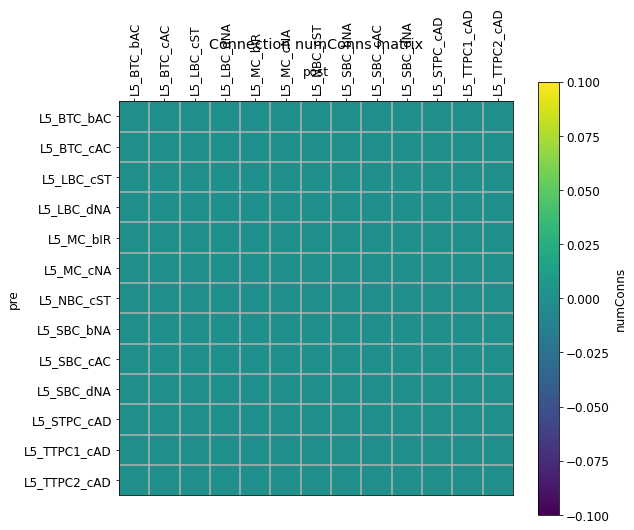

In [38]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=True, showFig=False);

In [39]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']
     
connNetPyNE = {}
for pre in subPopLabels:
    connNetPyNE[pre] = {}
    for post in subPopLabels:        
        connNetPyNE[pre][post] = 0
            
i=0
for pre in subPopLabels:
    for cellpre in cfg.popLabelEl[pre]:
        j=0
        for post in subPopLabels:
            for cellpost in cfg.popLabelEl[post]:
                 
                connBBP = float(connNumber[pre][post])
                if connBBP > 0:
                    synperconn = int(synperconnNumber[pre][post]+0.5)       

                    connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
#                 print(i,j,test[1]['connMatrix'][i][j]/synperconn)
                j+=1
        i+=1
  
for pre in subPopLabels:
    for post in subPopLabels:  
            connBBP = float(connNumber[pre][post])      
            if connBBP>0: # pre not in Epops and post not in Epops and 
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


	L5_BTC->L5_BTC  	 - 	  BBP =  36.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_LBC  	 - 	  BBP =  93.1   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_MC  	 - 	  BBP = 180.4   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_NBC  	 - 	  BBP =  81.0   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_SBC  	 - 	  BBP =   8.1   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_STPC  	 - 	  BBP = 233.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_TTPC1  	 - 	  BBP = 1896.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_BTC->L5_TTPC2  	 - 	  BBP = 1633.0   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_BTC  	 - 	  BBP = 140.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_LBC  	 - 	  BBP = 340.7   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_MC  	 - 	  BBP = 690.3   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_NBC  	 - 	  BBP = 335.7   	    NetPyNE =   0.0  	   Error = -100.0 %
	L5_LBC->L5_SBC  	 - 	 

Plotting 2D representation of network cell locations and connections...


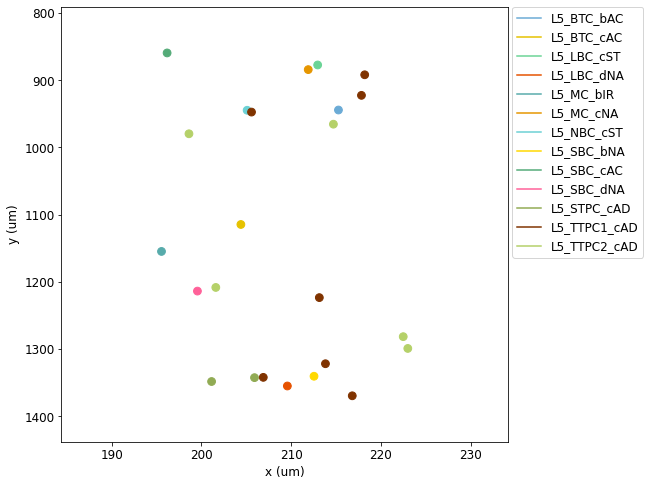

In [40]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=cfg.allpops,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


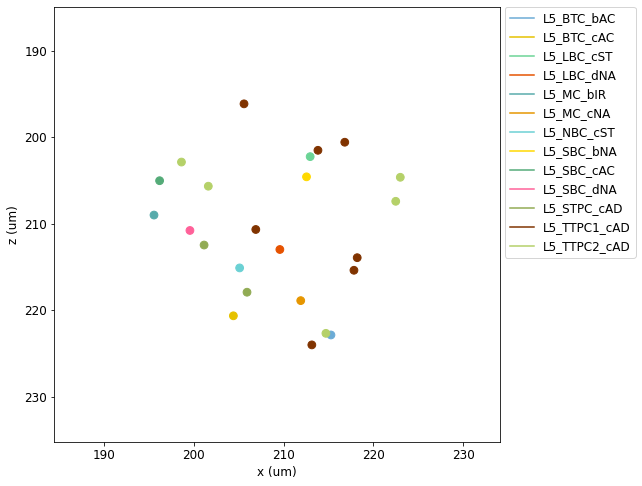

In [41]:
sim.analysis.plot2Dnet(include=cfg.allpops,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

Preparing spike data...
Plotting raster...


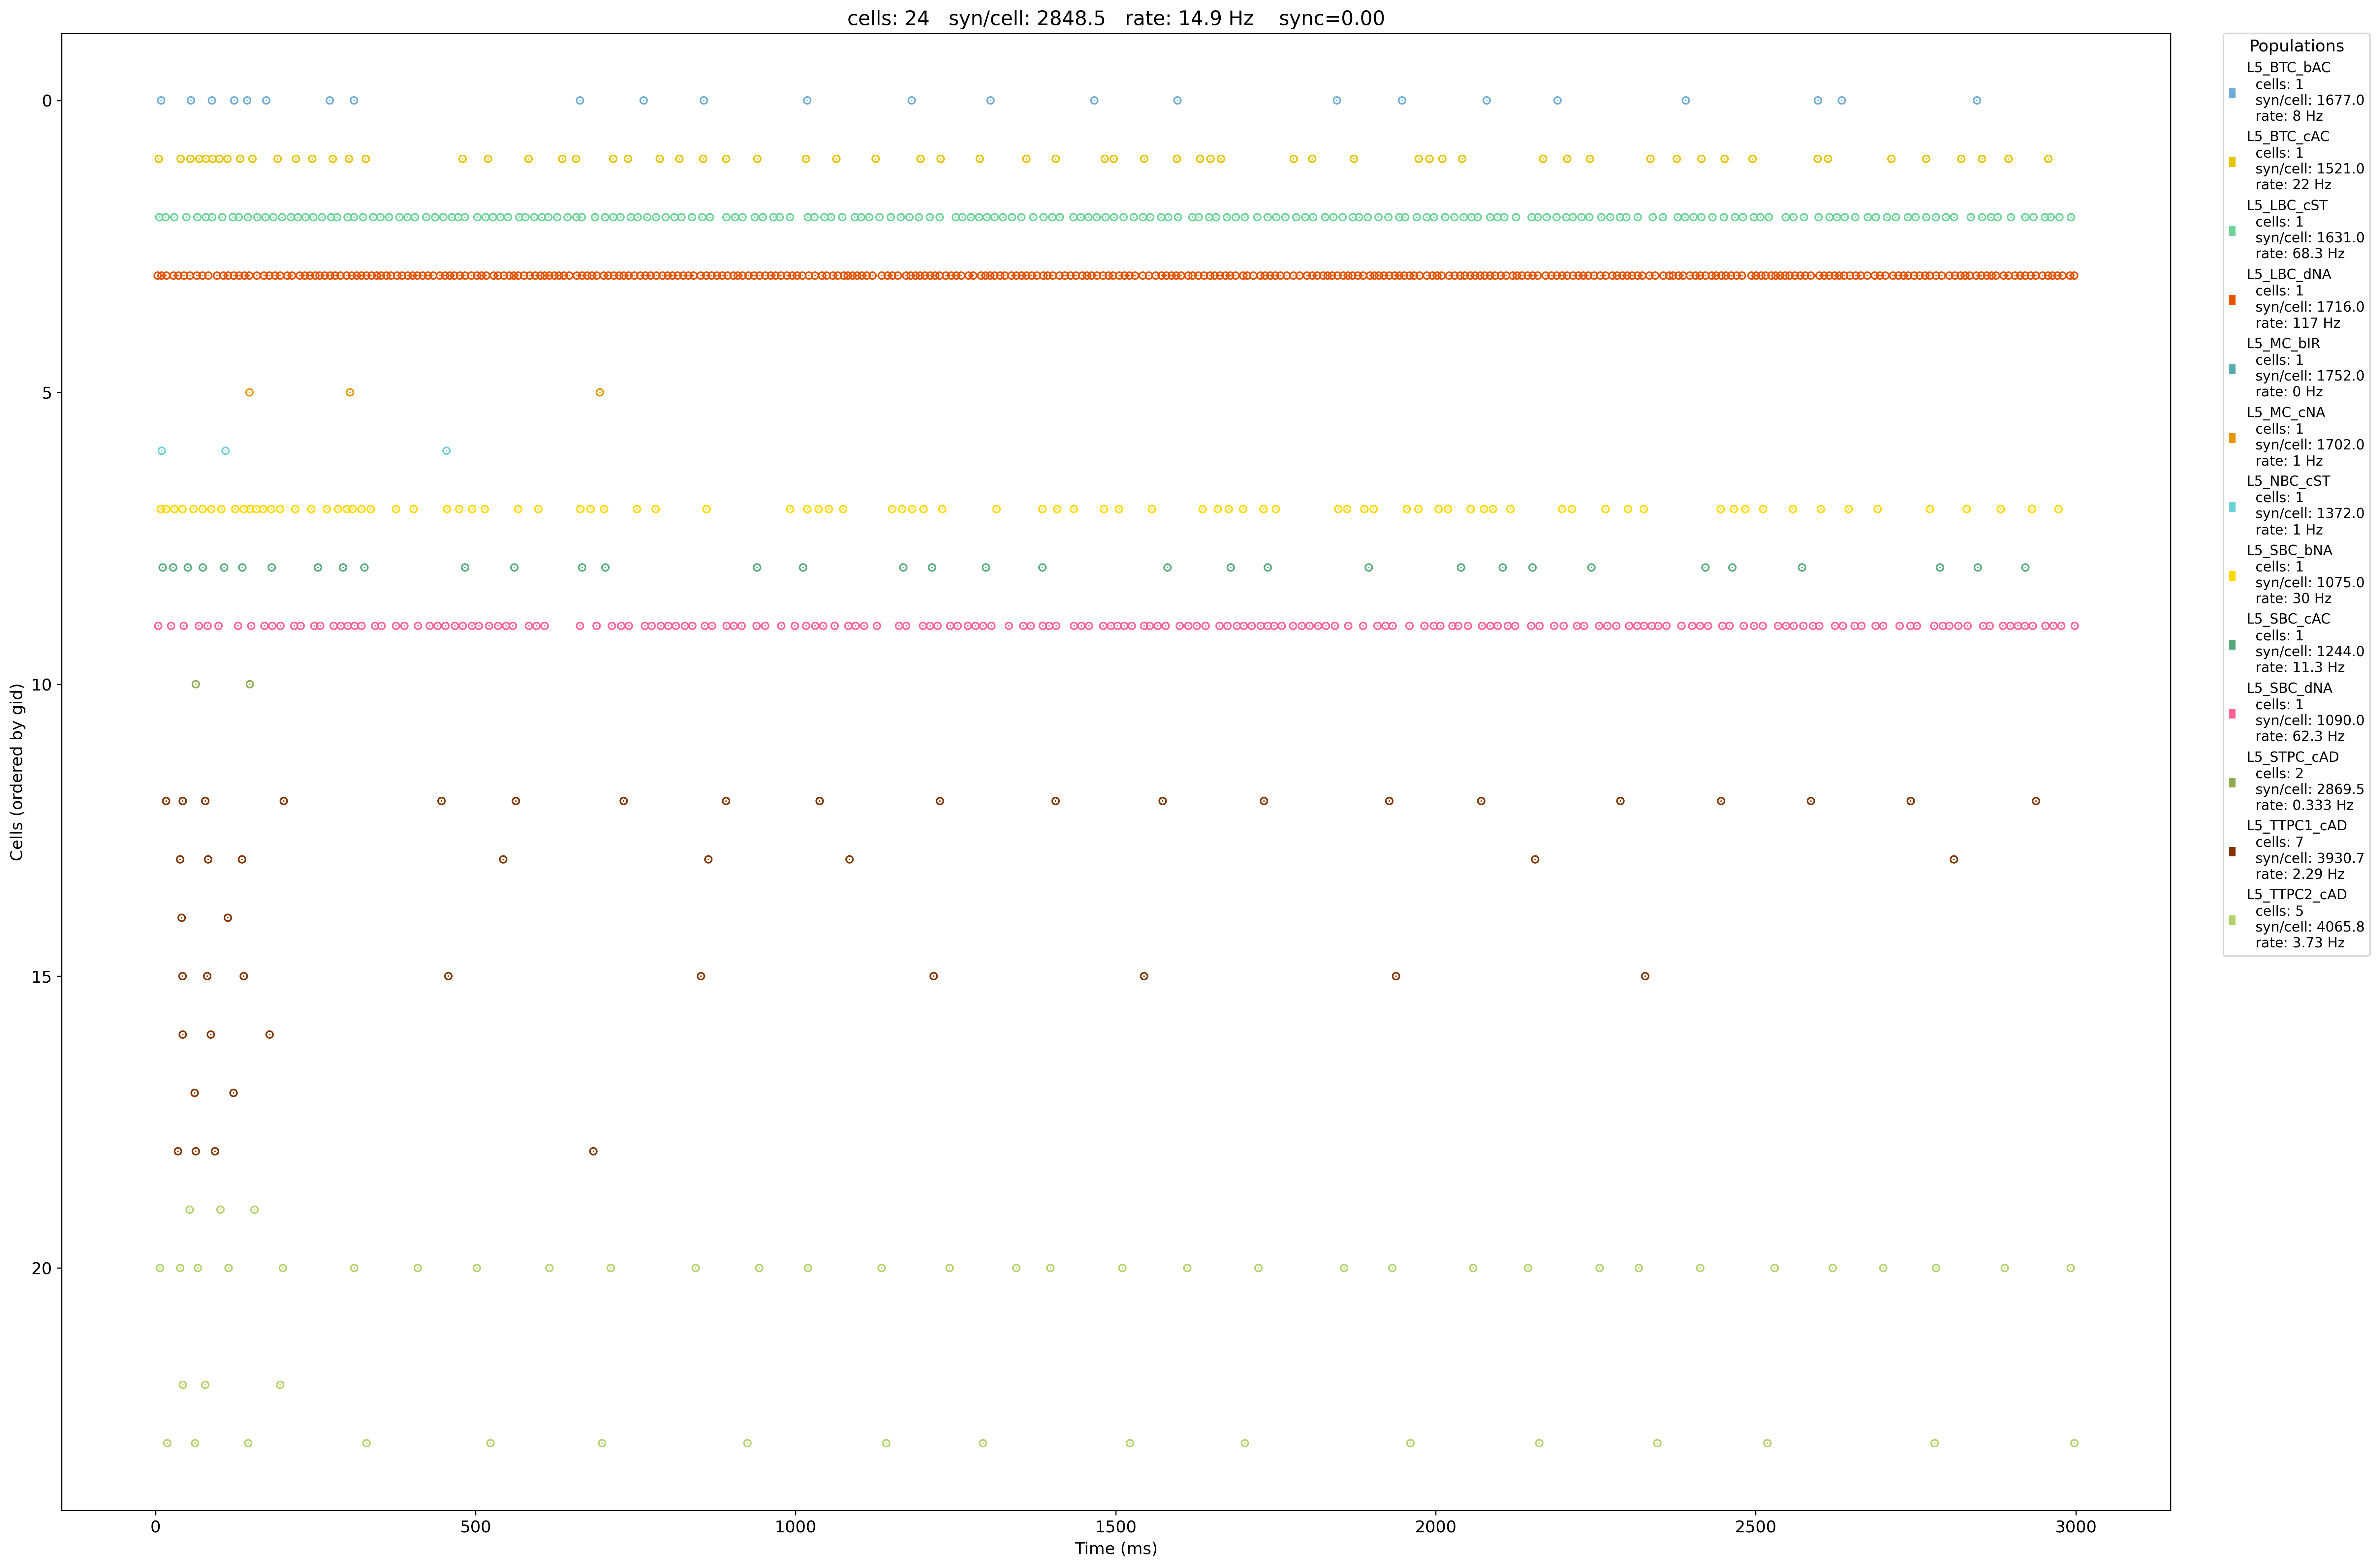

In [42]:
sim.analysis.plotRaster(include=cfg.allpops, timeRange=[0,cfg.duration], orderBy='gid', orderInverse=True, labels='legend', popRates=True, lw=5, marker='.', markerSize=24, figSize=(24, 16), fontSize=20, dpi=300, saveFig=True, showFig=False);

In [43]:
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

# traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
# traces



 L5_BTC_bAC   N = 13   Nmorpho = 1
Plotting recorded cell traces ... trace


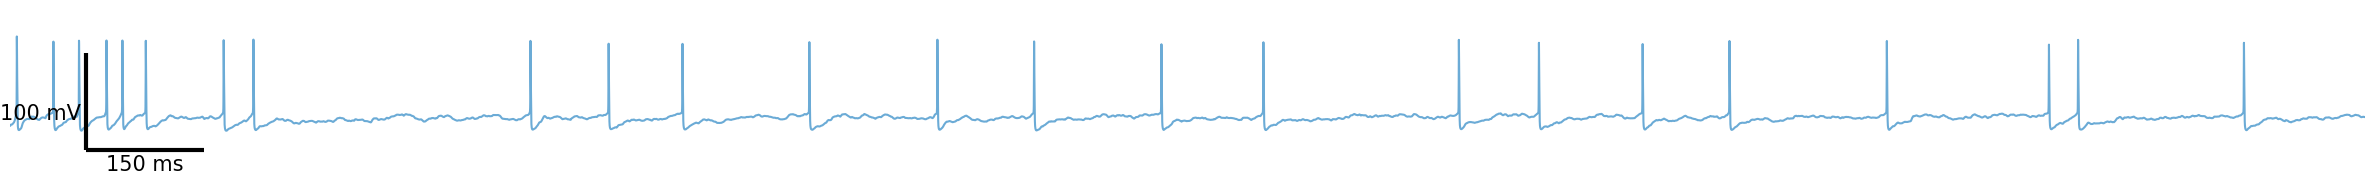



 L5_BTC_cAC   N = 50   Nmorpho = 1
Plotting recorded cell traces ... trace


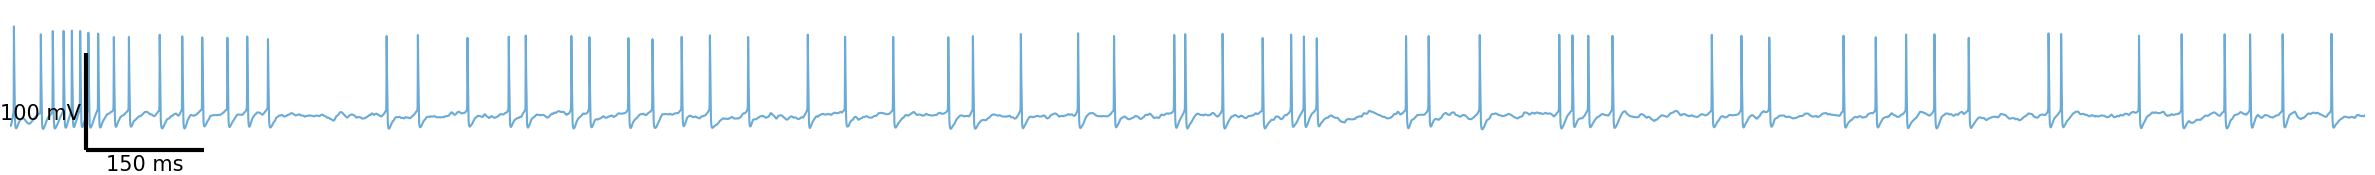



 L5_LBC_cST   N = 37   Nmorpho = 1
Plotting recorded cell traces ... trace


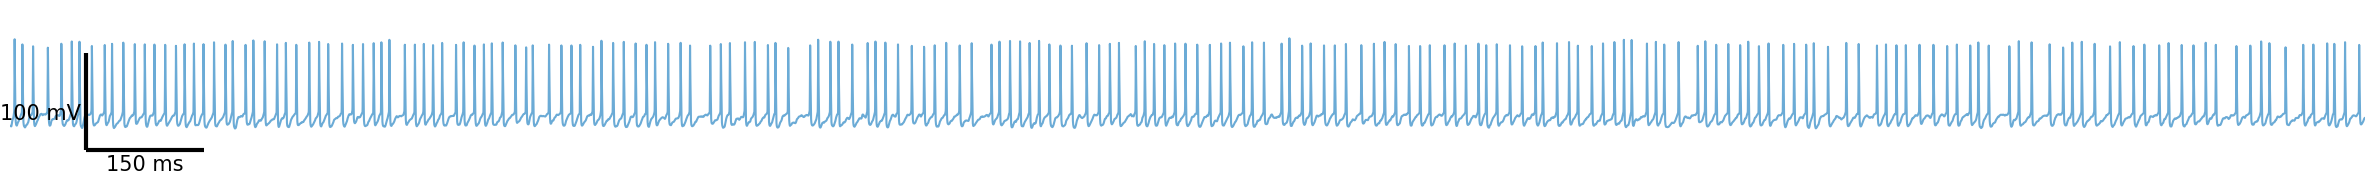



 L5_LBC_dNA   N = 37   Nmorpho = 1
Plotting recorded cell traces ... trace


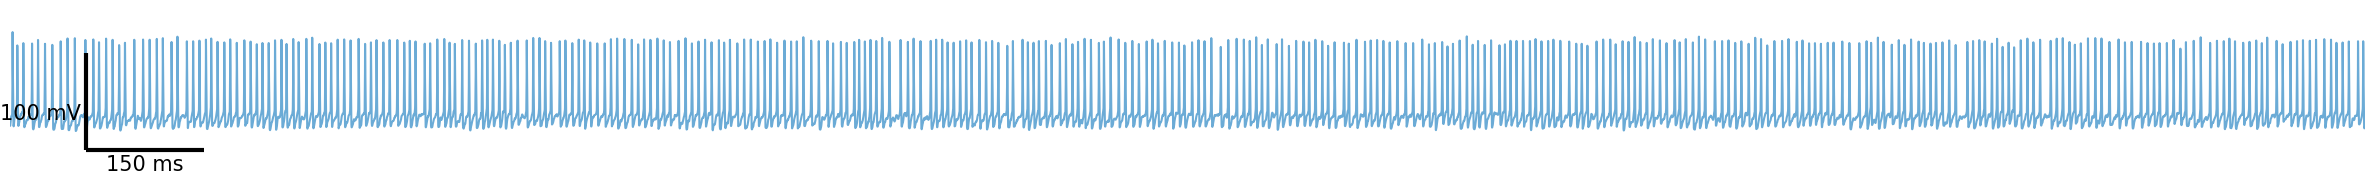



 L5_MC_bIR   N = 44   Nmorpho = 1
Plotting recorded cell traces ... trace


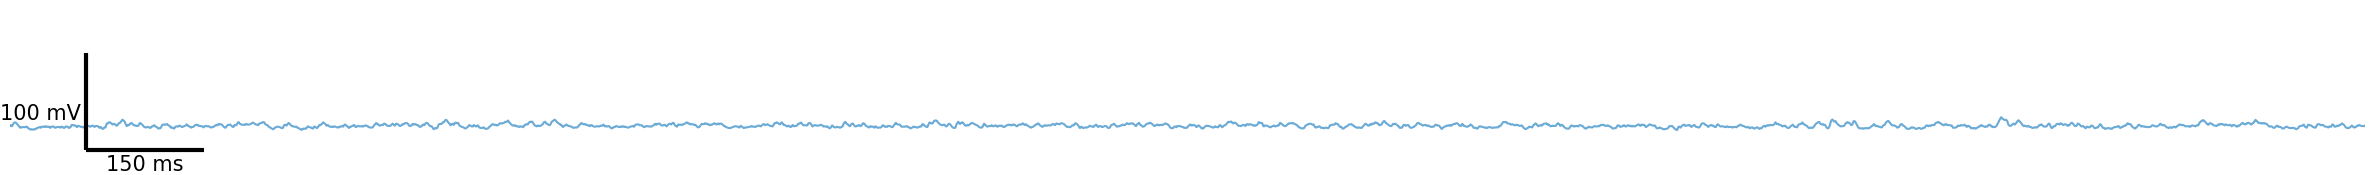



 L5_MC_cNA   N = 16   Nmorpho = 1
Plotting recorded cell traces ... trace


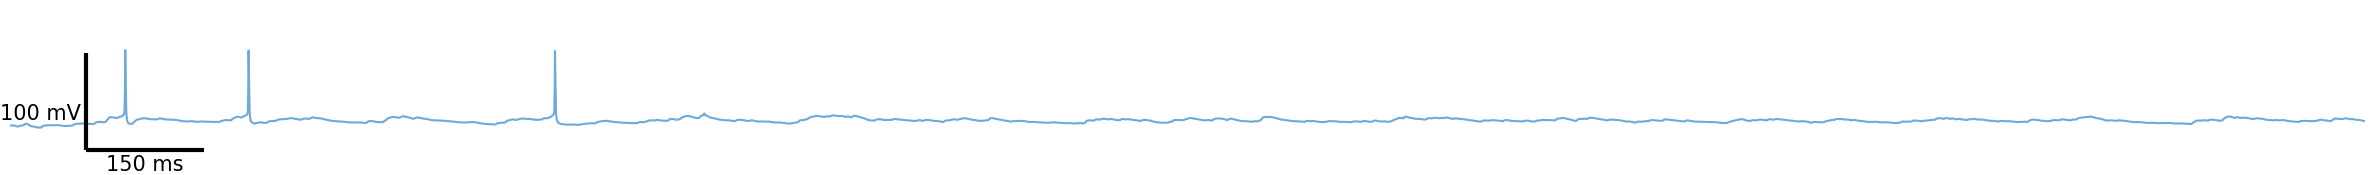



 L5_NBC_cST   N = 40   Nmorpho = 1
Plotting recorded cell traces ... trace


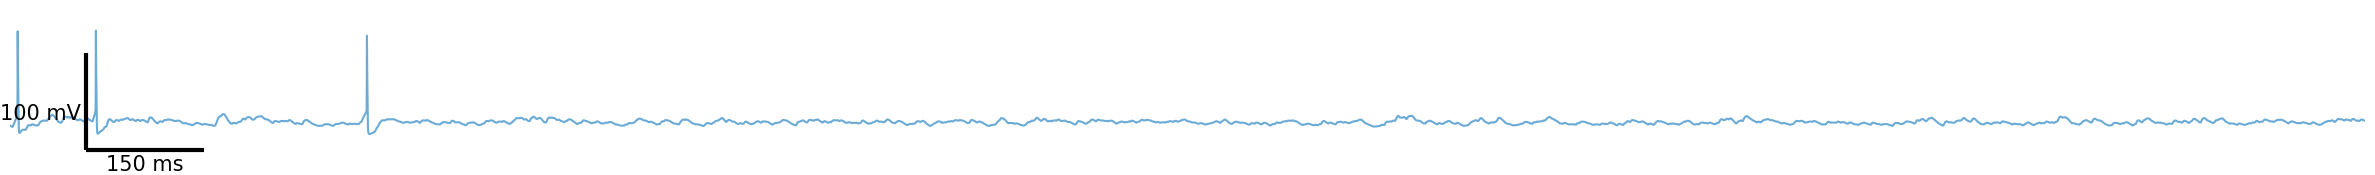



 L5_SBC_bNA   N = 9   Nmorpho = 1
Plotting recorded cell traces ... trace


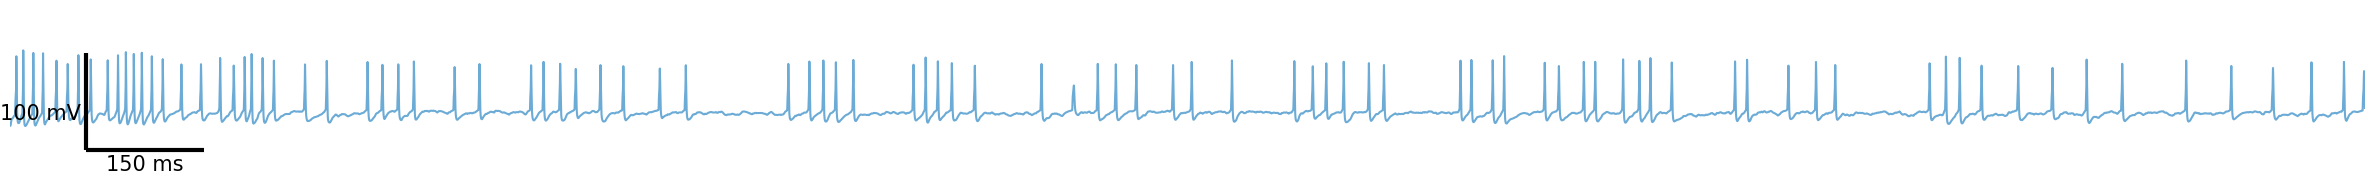



 L5_SBC_cAC   N = 9   Nmorpho = 1
Plotting recorded cell traces ... trace


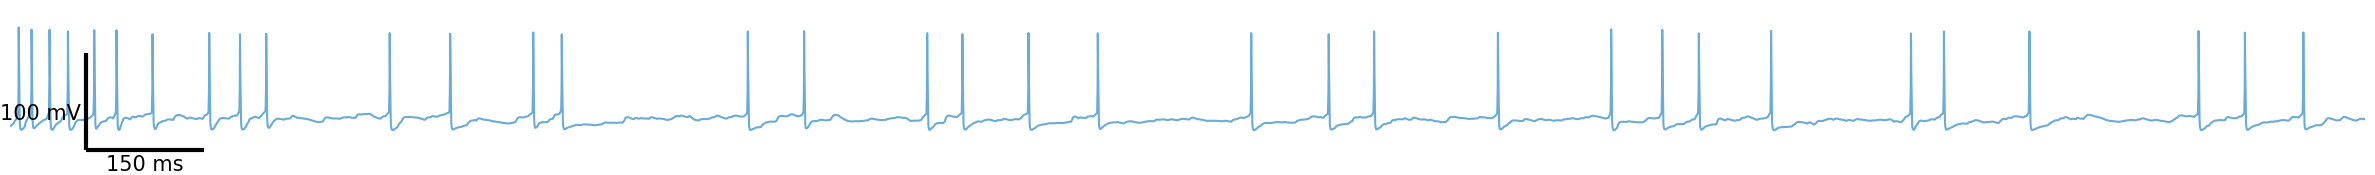



 L5_SBC_dNA   N = 7   Nmorpho = 1
Plotting recorded cell traces ... trace


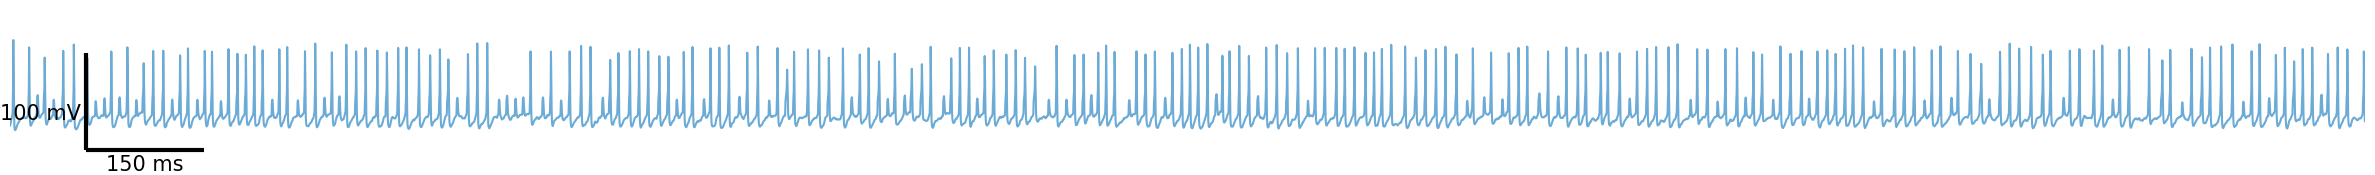



 L5_STPC_cAD   N = 302   Nmorpho = 2
Plotting recorded cell traces ... trace


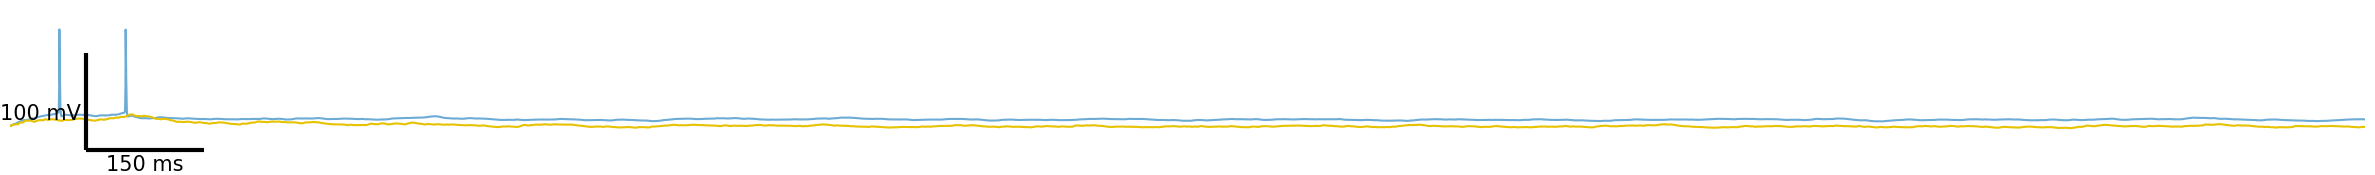



 L5_TTPC1_cAD   N = 2403   Nmorpho = 7
Plotting recorded cell traces ... trace


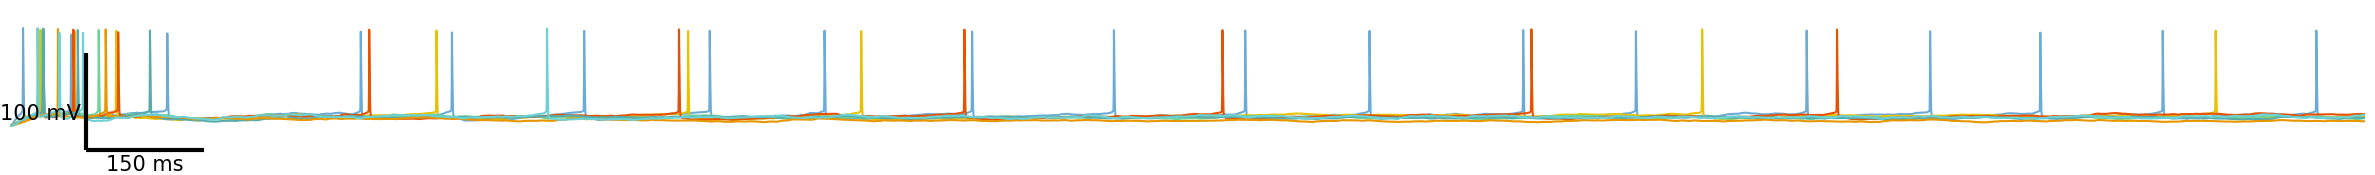



 L5_TTPC2_cAD   N = 2003   Nmorpho = 5
Plotting recorded cell traces ... trace


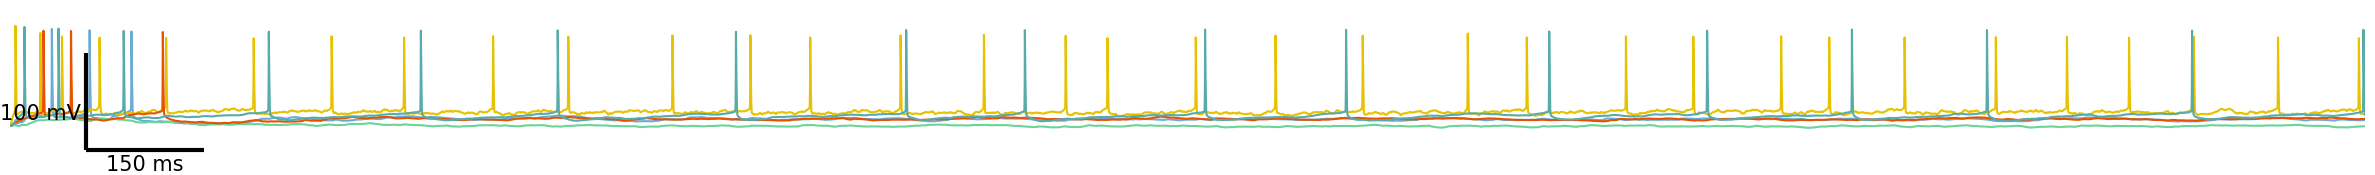

In [44]:
for pops in cfg.cellParamLabels:
    print('\n\n',pops,'  N =',cfg.cellNumber[pops],'  Nmorpho =',cfg.Nmorpho[pops])
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-110,50], axis=False, scaleBarLoc=3, figSize=(24, 2), fontSize=15, saveFig=cfg.saveFolder +'/'+cfg.simLabel +'_'+pops+ '_Vt.png');

In [45]:
sim.net.cells[-1].stims

[]

In [46]:
sim.net.cells[-1].conns

[]